In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
from sktime.transformations.hierarchical.aggregate import Aggregator
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.date import DateTimeFeatures

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import make_reduction

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder

from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor

from sktime.transformations.hierarchical.reconcile import Reconciler

from sktime.transformations.compose  import TransformerPipeline
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

# I/ Prepare DataSet

In [3]:
dates = pd.read_csv('m5/calendar.csv').reset_index()
dates['index'] = 'd_' + (dates['index'].astype(int)+1).astype(str)
dates =  dates.set_index('index')['date'].to_frame('ds')

In [4]:
df = pd.read_csv('m5/sales_train_evaluation.csv')

In [5]:
hierarchy = ['item_id','dept_id','cat_id','store_id','state_id']
index_hierarchy = df['item_id'] +'-'+ df['dept_id'] + '-'+ df['cat_id'] + '-'+ df['store_id'] + '-' + df['state_id']

In [6]:
df = df.set_index(hierarchy)

In [7]:
df['sum'] = df.sum(axis=1)
df = df.sort_values('sum', ascending=False)
df = df.iloc[:50].reset_index().drop('sum', axis=1)

In [8]:
df = pd.melt(df, id_vars= hierarchy, var_name='ds', value_name='y').set_index('ds')

In [9]:
df = df.merge(dates, left_index=True, right_index=True, how='left').set_index(hierarchy + ['ds'])
df.index = df.index.set_levels(pd.to_datetime(df.index.levels[-1]), level=-1)
df = df.sort_index()

# II/ Pipeline Building

In [10]:
def CategoricalEncoding(X_train, X_test, y_tr=None, EncodingType='OHE', col=None, index_col=True):
    X_tr, X_ts = X_train.copy(), X_test.copy()
    if index_col:
        col_name = f'index_{col}'
        X_tr[col_name] = X_tr.reset_index(col)[col].values
        X_ts[col_name] = X_ts.reset_index(col)[col].values
    else:
        col_name = col
    
    if EncodingType == 'OHE':
        ohe = OneHotEncoder(sparse_output=False).fit(X_tr[[col_name]])
        
        X_tr[ohe.get_feature_names_out()] = ohe.transform(X_tr[[col_name]])
        X_ts[ohe.get_feature_names_out()] = ohe.transform(X_ts[[col_name]])

        X_tr = X_tr.drop(col_name, axis=1)
        X_ts = X_ts.drop(col_name, axis=1)

    if EncodingType == 'Ordinal':
        le = OrdinalEncoder()
        
        X_tr[col_name] = le.fit_transform(X_tr[[col_name]])
        X_ts[col_name] = le.transform(X_ts[[col_name]])

    if EncodingType == 'Target':
        te = TargetEncoder(target_type='continuous', cv=2,)

        X_tr[col_name] = te.fit_transform(X_tr[[col_name]], y_tr.values.ravel())
        X_ts[col_name] = te.transform(X_ts[[col_name]])

    return X_tr, X_ts

In [11]:
class CatBoostRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.cat_features = kwargs.get('cat_features', [])
        self.model = CatBoostRegressor(**kwargs)

    def fit(self, X, y):
        X_ = X.copy()
        if self.cat_features:
            X_[self.cat_features] = X_[self.cat_features].astype(str).replace('nan', 'NoValue').astype('category')
        self.model.fit(X_, y)
        return self

    def predict(self, X):
        X_ = X.copy()
        if self.cat_features:
            X_[self.cat_features] = X_[self.cat_features].astype(str).replace('nan', 'NoValue').astype('category')
        return self.model.predict(X_)
    
    def get_model(self, deep=True):
        return self.model
    
    def get_params(self, deep=True):
        return self.kwargs

    def set_params(self, **params):
        self.kwargs.update(params)
        self.cat_features = self.kwargs.get('cat_features', [])
        self.model = CatBoostRegressor(**self.kwargs)
        return self

In [12]:
filter_kwargs = {'window_length': 16, 'n_sigma': 3}

fourrier_kwargs = {'sp_list': [365.25, 30.44, 7], 'fourier_terms_list': [8, 2, 1], 'freq': 'D', 'keep_original_columns': True}

date_kwargs = {'manual_selection' : ["day_of_week", "week_of_month", "is_weekend"], 'keep_original_columns': True}

window_kwargs =  {'lag_feature' : {
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,7], [14, 7], [22,7]],
        "std": [[1, 7], [1, 28], [7,7], [14, 7], [22,7]],
    }
}

catboost_kwargs = {'loss_function': "RMSE", 'has_time': True, 'verbose': False,
                  'cat_features': ['day_of_week', "week_of_month"]}

forecast_kwargs = {'window_length': None, 'strategy': "recursive", 'pooling': 'global', 'scitype': 'tabular-regressor'}

In [13]:
featurizer = TransformerPipeline(
        steps = [
            ("fourier_featurizer", FourierFeatures(**fourrier_kwargs)),
            ("datetime_featurizer", DateTimeFeatures(**date_kwargs)),
        ]
    )
forecaster = make_reduction(CatBoostRegressorWrapper(**catboost_kwargs),
                            **forecast_kwargs,
                            transformers=[WindowSummarizer(**window_kwargs, )])

In [14]:
from sktime.transformations.series.boxcox import LogTransformer


In [15]:
pipe = TransformedTargetForecaster(steps=[
        #("outlier", HampelFilter(**filter_kwargs)),
        #("imputer_interp", Imputer(method="linear")),
        #("imputer_extrap", Imputer(method="nearest")),
        ("aggregator", Aggregator()),
        #("boxcox", BoxCoxTransformer()), #LogTransformer(offset=1)
        #("detrender", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", forecaster),

])

# III/ Pre-Preprocessing


In [16]:
H = 30
target = ['y']

In [17]:
y_train, y_test = temporal_train_test_split(df, test_size=H)
y_test_full = Aggregator().fit_transform(y_test)
index_train, index_test = y_train.index, y_test.index
index_hier_ds_full = pd.concat([pd.DataFrame(None, index_train), pd.DataFrame(None, index_test)])

In [18]:
X_full = featurizer.fit_transform(index_hier_ds_full)
X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]

In [19]:
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'OHE', 'state_id')
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Target', 'store_id')
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'OHE', 'cat_id')
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Target', 'dept_id')
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Target', 'item_id')

X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Ordinal', 'day_of_week', False)
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Ordinal', 'week_of_month', False)

# IV/ Modelisation

In [20]:
pipe.fit(y_train, X_train);

In [21]:
y_pred_full = pipe.predict(np.arange(1,H+1).tolist(), X_test)

In [22]:
y_pred = y_pred_full[~y_pred_full.index.to_frame(index=False).apply(lambda x: x.astype(str).str.contains('__total')).any(axis=1).values]

In [23]:
y_pred_recon_full = Reconciler(method="ols").fit_transform(y_pred_full)
y_pred_recon = y_pred_recon_full[~y_pred_recon_full.index.to_frame(index=False).apply(lambda x: x.astype(str).str.contains('__total')).any(axis=1).values]

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


# V/ Resultats

In [24]:
MASE = np.zeros(len(index_test.droplevel(-1).drop_duplicates()))
sMAPE = np.zeros(len(index_test.droplevel(-1).drop_duplicates()))

for i, idx in enumerate(index_test.droplevel(-1).drop_duplicates()):
    y_test_tmp = y_test.loc[idx]
    y_pred_tmp = y_pred.loc[idx]
    y_train_tmp = y_train.loc[idx]
    
    MASE[i] = mean_absolute_scaled_error(y_test_tmp, y_pred_tmp, y_train=y_train_tmp)
    sMAPE[i] = mean_absolute_percentage_error(y_test_tmp, y_pred_tmp, symmetric=True)
    
pd.DataFrame(np.column_stack([MASE,sMAPE]), columns=['MASE', 'sMAPE']).describe()

,MASE,sMAPE
count,50.000000,50.000000
mean,0.784272,0.365060
std,0.233526,0.425641
min,0.439670,0.122088
25%,0.591875,0.187455
50%,0.738974,0.224603
75%,0.920278,0.326330
max,1.442033,1.969797


In [25]:
# for idx in index_test.droplevel(-1).drop_duplicates():
#     y_test_tmp = y_test.loc[idx]
#     y_pred_tmp = y_pred.loc[idx]
#     y_train_tmp = y_train.loc[idx]
  
#     print('Store:', idx)
#     #print("MSE:", mean_squared_error(y_test_tmp, y_pred_tmp))
#     print("MASE:", mean_absolute_scaled_error(y_test_tmp, y_pred_tmp, y_train=y_train_tmp))
#     #print("MAPE:", mean_absolute_percentage_error(y_test_tmp, y_pred_tmp))
#     print("sMAPE:", mean_absolute_percentage_error(y_test_tmp, y_pred_tmp, symmetric=True))

#     plt.plot(y_test_tmp.index, y_test_tmp.values, color='green', label = 'True')
#     plt.plot(y_pred_tmp.index,  y_pred_tmp.values, color='black', label='Pred')

#     plt.legend()
#     plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
#     plt.show()

# VI/ Explicativité

In [26]:
model_sp = pipe.get_fitted_params()['forecaster'].get_fitted_params()['estimator'].get_model()
cat_features_sp = model_sp.get_params()['cat_features']

In [27]:
from sktime.transformations.compose  import TransformerPipeline

pipe_sp = TransformerPipeline(steps=[
    #("outlier", HampelFilter(**filter_kwargs)),
    #("imputer_interp", Imputer(method="linear")),
    #("imputer_extrap", Imputer(method="nearest")),
    ("aggregator", Aggregator()),
    #("boxcox", BoxCoxTransformer()), #LogTransformer(offset=1)
    #("detrender", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("scale", TabularToSeriesAdaptor(StandardScaler())),
])

y_sp = pipe_sp.fit_transform(y_train)

In [28]:
X_sp = pd.concat([WindowSummarizer(**window_kwargs, ).fit_transform(y_sp), X_train])
X_sp = X_sp[model_sp.feature_names_]
X_sp[cat_features_sp] = X_sp[cat_features_sp].astype(str).replace('nan', 'NoValue').astype('category')

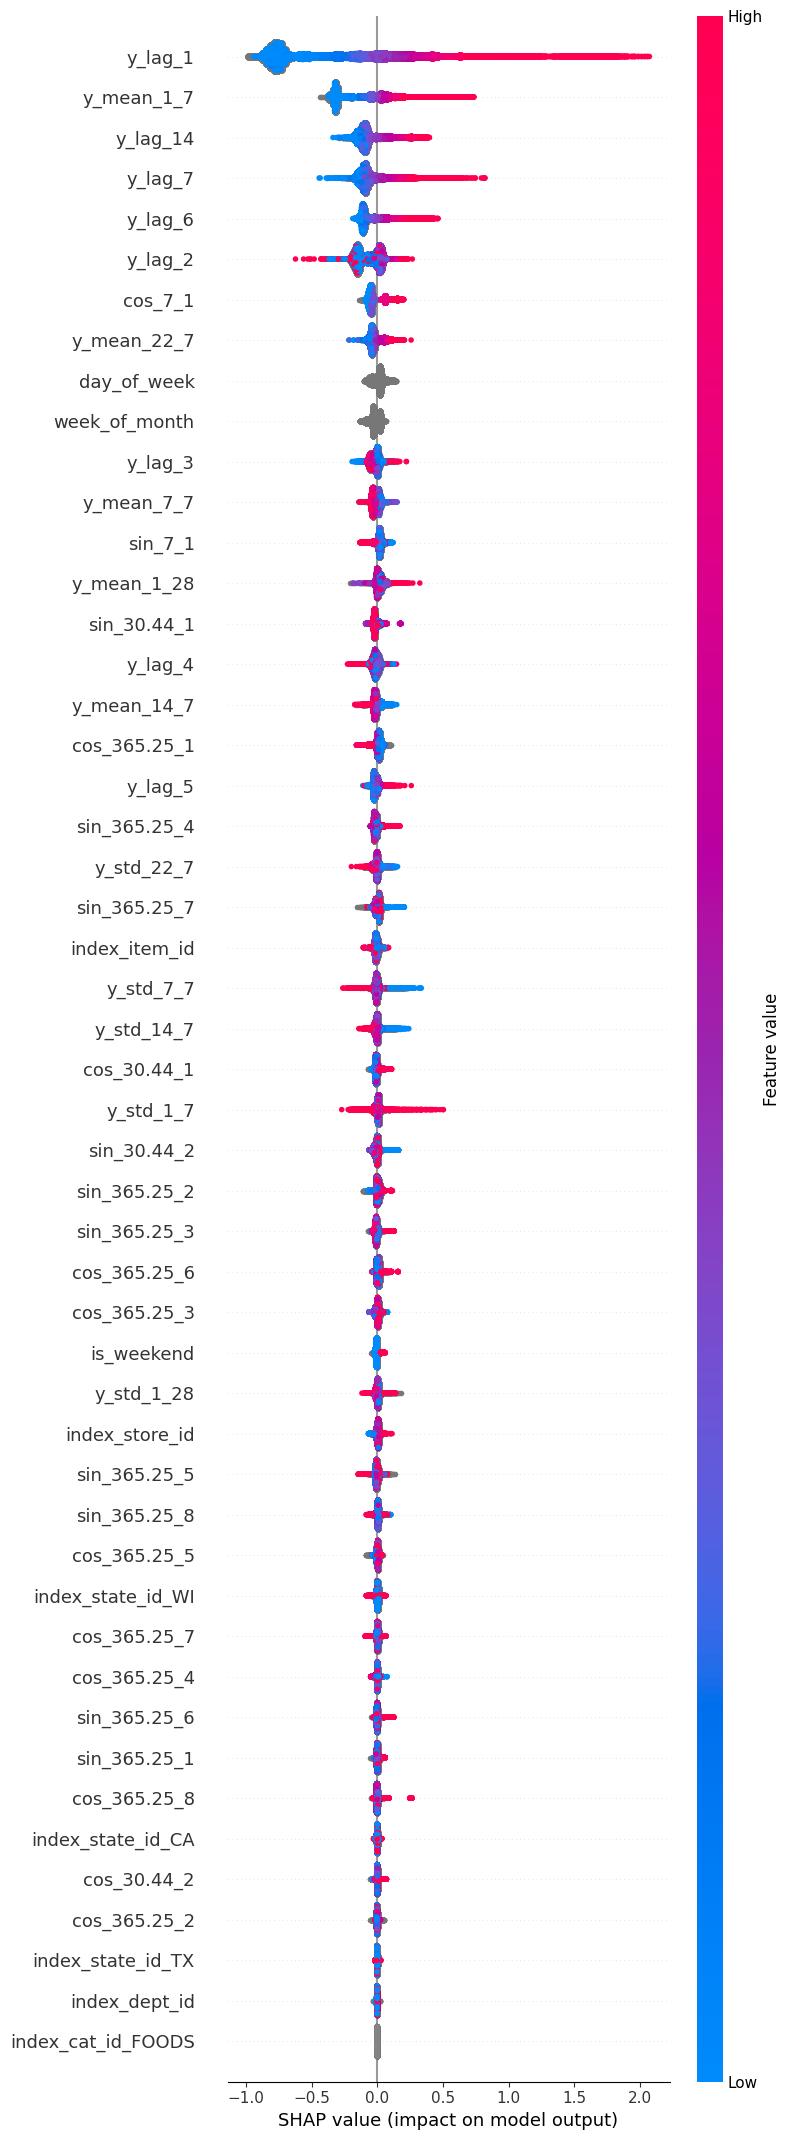

In [29]:
explainer = sp.TreeExplainer(model_sp)
shap_values = explainer.shap_values(X_sp)

sp.summary_plot(shap_values, X_sp, max_display=50)
plt.show()